In [42]:
pip install sentence_transformers

In [43]:
import pandas as pd
import numpy as np
from google.colab import drive
import nltk.data
import nltk
import json
import csv
from transformers import pipeline# sửa lỗi chính tả
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer # embedding câu
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random
import torch.optim.lr_scheduler as lr_scheduler

In [44]:

# Mô hình tokennizer sentence và sửa lỗi chính tả, embedding câu.
nltk.download('punkt')
class Panthera:
  def __init__(self):
    tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')
    fix_spelling = pipeline("text2text-generation",model="oliverguhr/spelling-correction-english-base")
    # fix_spelling= pipeline(
    #           'text2text-generation',
    #           'pszemraj/flan-t5-large-grammar-synthesis',
    #           )
    self.tokenize = tokenizer.tokenize
    self.fix_spelling = fix_spelling

  @staticmethod
  def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(Panthera.flatten(item))
        else:
            flat_list.append(item)
    return flat_list

  def execute(self,text, max_depth = 5, check_spelling = True):#1 đoạn văn bản
    # lặp lại cho đến khi không còn sự thay đổi nào
    list_tokens_sent = self.tokenize(text)

    if check_spelling:
      deep = 0
      while(True):
        for i in range(len(list_tokens_sent)):#duyệt list các token sent đã được chia tách, kiểm tra chính tả và sửa
          list_tokens_sent[i] = self.fix_spelling(list_tokens_sent[i], max_length = 2048)[0]['generated_text'] #, max_length = 2048


        # tiếp tục phân tách cho đến khi không thay đổi
        pre_len = len(list_tokens_sent)
        for i in range(len(list_tokens_sent)):
          list_tokens_sent[i] = self.tokenize(list_tokens_sent[i])

        # dãn list_tokens_sent thành 1 mảng chứa các token duy nhất
        list_tokens_sent = Panthera.flatten(list_tokens_sent)
        # kiểm tra thay đổi
        deep += 1
        if pre_len == len(list_tokens_sent) or deep == max_depth:
          break

    return list_tokens_sent
  @staticmethod
  def text2embedding(sentence):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Sentences are encoded by calling model.encode()
    embedding = model.encode(sentence)

    return torch.Tensor(embedding) if len(embedding.shape) >= 2 else torch.Tensor([embedding])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
# Tiền xử lí: thực hiện Panthera và ghi lại
class Rabbit:
  def __init__(self) -> None:
    self.call_function = False
    pass
  def get_file(self,function = None):
    # thực hiện các thao tác tạo file, lấy file,...
    if self.call_function:
      return "already"

    self.call_function = True

    if function == None:
      drive.mount('/content/drive')
      file_path = '/content/drive/My Drive/data_mining_project/Data-for-Data-Mining-Project - Source.csv'

      file_path_save = '/content/drive/My Drive/data_mining_project/Comment_Sentiment.csv'
      # pd.DataFrame(columns = ['ID','Tokenize Sentence', 'Label']).to_csv(file_path_save, header=True, index=False, mode = 'w')

      children_leopard = Panthera()

      df = pd.read_csv(file_path)

      header = True

      for i in range(df.shape[0]):
        sub_df = df.iloc[[i]]
        text = sub_df['Review Title'] + '. ' + sub_df['Review Content']
        text = text.values[0]
        data = {'ID':i,'Tokenize Sentence':children_leopard.execute(text), 'Label':sub_df['Label'].values[0]}
        print(data)

        # Lưu từ điển vào tệp CSV
        file_path = file_path_save
        my_dict = data
        with open(file_path, 'a', newline='') as csvfile:
            fieldnames = my_dict.keys()
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if header:
              writer.writeheader()
              header = False
            writer.writerow(my_dict)

    else:
       return function

In [46]:
# children_rabbit = Rabbit()
# children_rabbit.get_file()

# đã ghi

In [47]:
class Data(Dataset):#dữ liệu phải có dạng: một cột là các comment, mỗi comment đã được phân tách thành list các câu, cột còn lại là sentiment positive, negative
  def __init__(self, data, target):
        self.data = data
        self.target = target

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    # print(index)
    x = self.data[index]
    y = self.target[index]
    return x, y

class PrepareData():
  '''
  Đầu vào vẫn là các list thông thường
  '''
  def __init__(self, data, target) -> None:
    dataset = Data(data, target)

    self.trainset, self.validationset, self.testset = random_split(dataset, [0.8, 0.1, 0.1])

  @staticmethod
  def collate_fn(batch):
    # Sắp xếp các mẫu trong batch theo độ dài chuỗi giảm dần
    batch.sort(key=lambda x: len(x[0]), reverse=True)


    # batch = [(data1, label1), (data2, label2), ...].Bằng cách sử dụng zip(*batch), chúng ta thực hiện unpack các thành phần của batch theo chiều dọc

    # Tách dữ liệu và nhãn từ các mẫu
    data, labels = zip(*batch)
    labels = torch.Tensor(labels)

    # Tạo batch tensor bằng cách padding các sequence trong list
    padded_sequences = nn.utils.rnn.pad_sequence(data, batch_first=True)

    # Đếm độ dài thực tế của mỗi sequence trong batch
    sequence_lengths = [len(seq) for seq in data]


    # Chuyển đổi batch tensor thành PackedSequence
    packed_sequence = torch.nn.utils.rnn.pack_padded_sequence(padded_sequences, sequence_lengths, batch_first=True)

    return packed_sequence, labels

  def getData(self, batch_size, download = True):
    if download:
      path_train_loader = '/content/drive/My Drive/data_mining_project/train_loader.pkl'
      path_validation_loader = '/content/drive/My Drive/data_mining_project/validation_loader.pkl'
      path_test_loader = '/content/drive/My Drive/data_mining_project/test_loader.pkl'

      with open(path_train_loader, 'rb') as f:
        train_loader = pickle.load(f)

      with open(path_validation_loader, 'rb') as f:
        validation_loader = pickle.load(f)

      with open(path_test_loader, 'rb') as f:
        test_loader = pickle.load(f)


      train_loader = torch.utils.data.DataLoader(train_loader.dataset, batch_size=batch_size,
                                                  shuffle=True,collate_fn=PrepareData.collate_fn, num_workers=0, pin_memory=False)
      validation_loader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size,
                                                  shuffle=False,collate_fn=PrepareData.collate_fn, num_workers=0, pin_memory=False)
      test_loader = torch.utils.data.DataLoader(self.validationset, batch_size=batch_size,
                                                shuffle=False,collate_fn=PrepareData.collate_fn, num_workers=0, pin_memory=False)

      return train_loader, validation_loader, test_loader


    else:
      train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size,
                                                  shuffle=True,collate_fn=PrepareData.collate_fn, num_workers=0, pin_memory=False)
      validation_loader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size,
                                                  shuffle=False,collate_fn=PrepareData.collate_fn, num_workers=0, pin_memory=False)
      test_loader = torch.utils.data.DataLoader(self.validationset, batch_size=batch_size,
                                                shuffle=False,collate_fn=PrepareData.collate_fn, num_workers=0, pin_memory=False)

      return train_loader, validation_loader, test_loader


In [48]:
# Mô hình LSTM, trước hết biến đổi 1 câu thành embedding

# Xây dựng lớp mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout = 0.2, numlayers = 1, bidirectional = False):
        super(LSTMModel, self).__init__()
        self.num_layers = numlayers
        self.D = 2 if bidirectional else 1

        self.hidden_dim = hidden_dim # có giá trị tự do
        self.embedding_dim = embedding_dim # chiều của embedding, vd: [1,2,3,...300]: 1 embedding có kích thước là 300
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True, num_layers = numlayers, dropout = dropout, bidirectional=bidirectional) # đầu vào của LSTM là có kích thước embedding và đầu ra có kích thước hidden, xây dựng 1 mô hình LSTM
        # input_size = embedding_dim; hidden_size, num_layer
        # tuning ở ngay trên
        self.fc = nn.Linear(self.D*hidden_dim, output_dim) # 1 fully conected để làm đầu ra



    def forward(self, inputs):

        '''
        đầu vào input lần lượt là: batch_size, sequence_length, embedding_dim
        '''
        # inputs = torch.nn.utils.rnn.pack_padded_sequence(inputs, )

        batch_size = inputs.batch_sizes[0].item()#input ở đây chính là 1 batch mà chúng ta cho vào, và tập huấn luyện của chúng ta chứa những inputs này
        hidden = self.init_hidden(batch_size)
        lstm_out, _ = self.lstm(inputs, hidden)

        # Giải nén lstm_out
        padded_outputs, _ = pad_packed_sequence(lstm_out, batch_first=True)


        padded_outputs = padded_outputs[:, -1, :]

        output = self.fc(padded_outputs)
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(self.D * self.num_layers, batch_size, self.hidden_dim),# gồm 1 phần chứa batch_size 'phần', 'phần' chứa hidden_dim units
                torch.zeros(self.D * self.num_layers, batch_size, self.hidden_dim))


class Tiger:#huấn luyện và predict
  def __init__(self, data, target, model = None,hidden_dim = 128, dropout = 0.0, numlayers = 1, bidirectional = False, batch_size = 4, lr = 0.01, gammar = 0.1):
    if model == None:
      embedding_dim = 384

      output_dim = 1
      model = LSTMModel(embedding_dim, hidden_dim, output_dim, dropout=dropout, numlayers = numlayers, bidirectional = bidirectional)
      self.model = model
    else:
      self.model = model

    preparedata = PrepareData(data, labels)
    self.train_loader ,self.validation_loader,self.test_loader = preparedata.getData(batch_size)

    self.max_sequence_length = 128

    self.lr = lr

    self.gammar = gammar

    pass
  def get_train_valid_test(self):
    return self.train_loader ,self.validation_loader, self.test_loader

  def train(self, earlystop_train = False):
    # Khởi tạo mô hình

    # Định nghĩa hàm mất mát và bộ tối ưu hóa
    criterion = nn.BCEWithLogitsLoss()# kết hợp giữa sigmoid và BCE
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=self.gammar)
    # Huấn luyện mô hình
    all_train_loss = []
    all_validation_loss = []
    all_accuracy = []

    best_loss = float('inf')
    early_stop_counter = 0
    patience = 5

    for epoch in range(50):
      self.model.train()
      # self.train_loader.shuffle()

      train_loss = 0

      for inputs, labels in self.train_loader:
          optimizer.zero_grad()
          outputs = self.model(inputs)

          loss = criterion(outputs.squeeze(), labels)
          train_loss += loss.item() * inputs.batch_sizes[0]

          loss.backward()
          optimizer.step()

      train_loss /= len(self.train_loader.dataset)
      all_train_loss.append(train_loss)
      # Bước giảm learning rate
      scheduler.step()

      self.model.eval()
      with torch.no_grad():
        correct = 0
        total = 0
        validation_loss = 0
        for inputs, labels in self.validation_loader:
            outputs = self.model(inputs).squeeze()
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * inputs.batch_sizes[0]

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)

            correct += (predicted_labels == labels.float()).sum().item()

        accuracy = correct / total
        validation_loss /= len(self.validation_loader.dataset)

        all_validation_loss.append(validation_loss)
        all_accuracy.append(accuracy)

        if earlystop_train:
          if train_loss < best_loss:
              best_loss = train_loss
              early_stop_counter = 0
          else:
              early_stop_counter += 1
              if early_stop_counter >= patience:
                  break
        else:
          if validation_loss < best_loss:
              best_loss = validation_loss
              early_stop_counter = 0
          else:
              early_stop_counter += 1
              if early_stop_counter >= patience:
                  break

    return all_train_loss, all_validation_loss, all_accuracy



  def test(self):
    # Đánh giá mô hình trên dữ liệu kiểm tra
    self.model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in self.test_loader:
            outputs = self.model(inputs).squeeze()

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)

            correct += (predicted_labels == labels.float()).sum().item()

        accuracy = correct / total
    return accuracy

  def predict(self,text, check_spelling = False):# một đoạn hoàn chỉnh
    # chuyển về tokenizton sentence
    panthera = Panthera()
    tokens = panthera.execute(text, check_spelling)

    if len(tokens) > self.max_sequence_length:
      indices = random.sample(range(len(tokens)), self.max_sequence_length)
      indices.sort()
      tokens = [tokens[i] for i in indices]

    new_data = Panthera.text2embedding(tokens)
    new_data = new_data.unsqueeze(0)

    sequence_lengths = [len(seq) for seq in new_data]

    new_data = pack_padded_sequence(new_data, sequence_lengths, batch_first=True)

    # print(new_data.size())

    self.model.eval()
    with torch.no_grad():
        inputs = new_data
        outputs = self.model(inputs)#gọi hàm forward

        proba_label = torch.sigmoid(outputs)
        predict_label = (torch.sigmoid(outputs) > 0.5).float()


    return proba_label, 'positive' if predict_label == 1 else 'negative'

In [49]:
drive.mount('/content/drive')

path = '/content/drive/My Drive/data_mining_project/Comment_Sentiment.csv'
path_save = '/content/drive/My Drive/data_mining_project/Sub_Embedding.csv'
df = pd.read_csv(path)

df['Tokenize Sentence'] = df['Tokenize Sentence'].apply(lambda x: eval(x))
length = [len(cell) for cell in df['Tokenize Sentence']]
max_length = max(length)
min_length = min(length)
mean_length = np.mean(length)
print(f"max_length {max_length} \n min_length {min_length} \n {mean_length}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
max_length 51 
 min_length 1 
 5.643643643643643


In [50]:
MAX_SEQUENCE_LENGTH = 128

In [51]:
df_head_20 = df

# df_head_20['Tokenize Sentence'] = df_head_20['Tokenize Sentence'].apply(lambda x: eval(x))

data = [Panthera.text2embedding(df_head_20['Tokenize Sentence'].iloc[i]) for i in df_head_20.index]
labels = [0 if label == 'Negative' else 1 for label in df_head_20['Label']]


In [52]:
# tiger = Tiger(data, labels)

# print(tiger.train(earlystop_train = True))
# print(tiger.test())
# tiger.predict("I love this")


([tensor(0.6188), tensor(0.5419), tensor(0.5163), tensor(0.5268), tensor(0.5248), tensor(0.5187), tensor(0.5093), tensor(0.5181), tensor(0.5279), tensor(0.5253), tensor(0.5114), tensor(0.5145)], [tensor(0.5353), tensor(0.5491), tensor(0.5418), tensor(0.5412), tensor(0.5411), tensor(0.5411), tensor(0.5411), tensor(0.5411), tensor(0.5411), tensor(0.5411), tensor(0.5411), tensor(0.5411)], [0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7])
0.696969696969697


'positive'

In [53]:
# tunning hyperparameter

import optuna

def objective(trial):
  # hidden_dim = 128, dropout = 0.0, numlayers = 1, bidirectional = False, batch_size = 4, lr = 0.01, gammar = 0.1
  hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
  dropout = trial.suggest_float('dropout', 0, 0.5)
  num_layers = trial.suggest_int('num_layers', 1, 4)
  bidirectional = trial.suggest_categorical('bidirectional', [True, False])
  batch_size = trial.suggest_categorical('batch_size', [2, 4, 8, 16])
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
  gammar = trial.suggest_loguniform('gammar', 1e-3, 1e-1)

  tiger = Tiger(data, labels, model = None,hidden_dim = hidden_dim, dropout = dropout, numlayers = num_layers,
                bidirectional = bidirectional, batch_size = batch_size, lr = lr, gammar = gammar)
  _, target_value,_ = tiger.train()
  target_value = target_value[-1].item()
  return target_value
study = optuna.create_study()
study.optimize(objective, n_trials=100)

# Truy cập vào giá trị tốt nhất và siêu tham số tương ứng
best_params = study.best_params
best_value = study.best_value

print('Best Parameters:', best_params)
print('Best Value:', best_value)

[I 2024-03-28 19:16:46,710] A new study created in memory with name: no-name-a6475b85-8f3b-40ac-8b4b-a2f874d41911
<ipython-input-53-47858bf4fbe8>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-53-47858bf4fbe8>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gammar = trial.suggest_loguniform('gammar', 1e-3, 1e-1)
[I 2024-03-28 19:17:32,770] Trial 0 finished with value: 0.6938409209251404 and parameters: {'hidden_dim': 256, 'dropout': 0.19284345863427543, 'num_layers': 2, 'bidirectional': True, 'batch_size': 16, 'learning_rate': 1.4303570548574057e-05, 'gammar': 0.001474288995543751}. Best is t

Best Parameters: {'hidden_dim': 256, 'dropout': 0.40934921363817667, 'num_layers': 1, 'bidirectional': False, 'batch_size': 2, 'learning_rate': 0.00413446354929088, 'gammar': 0.015636526910698563}
Best Value: 0.33568206429481506


In [54]:

tiger = Tiger(data, labels,None,256,0.40934921363817667,1,False,2, 0.00413446354929088,0.015636526910698563)

print(tiger.train(earlystop_train = True))
print(tiger.test())
tiger.predict("I love this")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40934921363817667 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


([tensor(0.5508), tensor(0.4295), tensor(0.4132), tensor(0.4067), tensor(0.4330), tensor(0.4195), tensor(0.4135), tensor(0.4103), tensor(0.4130)], [tensor(0.4217), tensor(0.4084), tensor(0.4082), tensor(0.4082), tensor(0.4082), tensor(0.4082), tensor(0.4082), tensor(0.4082), tensor(0.4082)], [0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81])
0.7373737373737373


'positive'

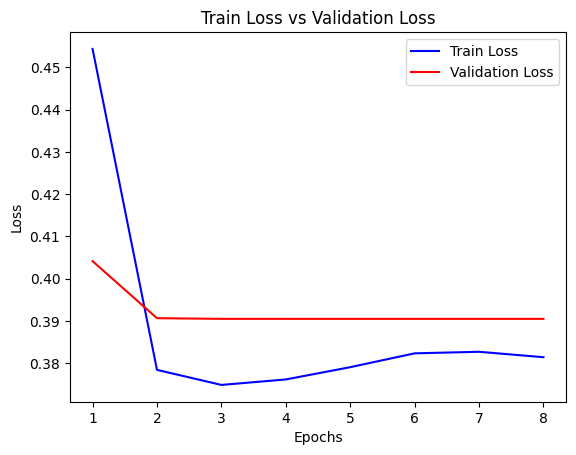

In [55]:
import matplotlib.pyplot as plt

train_loss ,val_loss,_ =  tiger.train(earlystop_train = True)

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
prepare = PrepareData(data, labels)
train_loader, validation_loader, test_loader = prepare.getData(4)

import pickle

path_train_loader = '/content/drive/My Drive/data_mining_project/train_loader.pkl'
path_validation_loader = '/content/drive/My Drive/data_mining_project/validation_loader.pkl'
path_test_loader = '/content/drive/My Drive/data_mining_project/test_loader.pkl'

with open(path_train_loader, 'wb') as f:
    pickle.dump(train_loader, f)

with open(path_validation_loader, 'wb') as f:
  pickle.dump(validation_loader, f)

with open(path_test_loader, 'wb') as f:
  pickle.dump(test_loader, f)

In [67]:

with open(path_train_loader, 'rb') as f:
    manhdataloader = pickle.load(f)

new_dataloader = torch.utils.data.DataLoader(
    manhdataloader.dataset, batch_size=10)
new_dataloader.batch_size

10